# TrES-3b transmission spectroscopy: light curve creation

The light curves are created from the spectra in the directory `data/spectra`. The wavelength calibration is calculated in `001_Wavelength_calibration.ipynb` and stored as a pickle in `results/wl_calibration.pkl`.

 - The comparison star is on CCD 1
 - The target star is on CCD 2
 
The light curves are generated for 16 narrow passbands and a broad 'white' passband. Both masked and unmasked versions are created. The passbands are defined using a [generalized Gaussian](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.general_gaussian.html#scipy.signal.general_gaussian) window function.

$$
F(x) = e^{- \frac{1}{2} \left|\frac{x-c}{\sigma}\right|^{2p}}
$$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math as mt
import pandas as pd
import pyfits as pf
import seaborn as sb

from glob import glob
from os.path import join
from pandas import DataFrame as DF
from astropy.time import Time
from scipy.signal import medfilt as mf

from core import *

sb.set_context('paper')
sb.set_style('white')
cp = sb.color_palette()

def normalise(lc):
    msk = ones(spectra_2.shape[0], np.bool)
    msk[45:190] = False
    return lc / median(lc[msk])

## Create the spectra

In [3]:
data_dir = 'data/spectra/'
sfiles_1 = sorted(glob(join(data_dir,'*_1.ms.fits')))
sfiles_2 = sorted(glob(join(data_dir,'*_2.ms.fits')))

In [5]:
spectra_1 = array([pf.getdata(sf) for sf in sfiles_1]).astype(np.float64)
spectra_2 = array([pf.getdata(sf) for sf in sfiles_2]).astype(np.float64)

## Read in the wavelength solutions 

The spectra have been extracted using a subsection from the original CCD (also along the dispersion axis), this must be accounted for when calculating the wavelength table.

In [6]:
wls = load(join('results','wl_calibration.pkl'), 'r')
ccdsec = eval('['+pf.getval(sfiles_2[0],'ccdsec').split(',')[-1].replace(':',','))
pixels = arange(ccdsec[0], ccdsec[1]+1)

wl1 = wls['ccd1'].pixel_to_wl(pixels)
wl2 = wls['ccd2'].pixel_to_wl(pixels)

## Plot the spectra 

In [9]:
pb_centers    = 540. + arange(16)*25
pb_filters_nb = [GeneralGaussian('nb', c, 12, 20) for c in pb_centers]
pb_filter_bb  = WhiteFilter('white', pb_filters_nb)

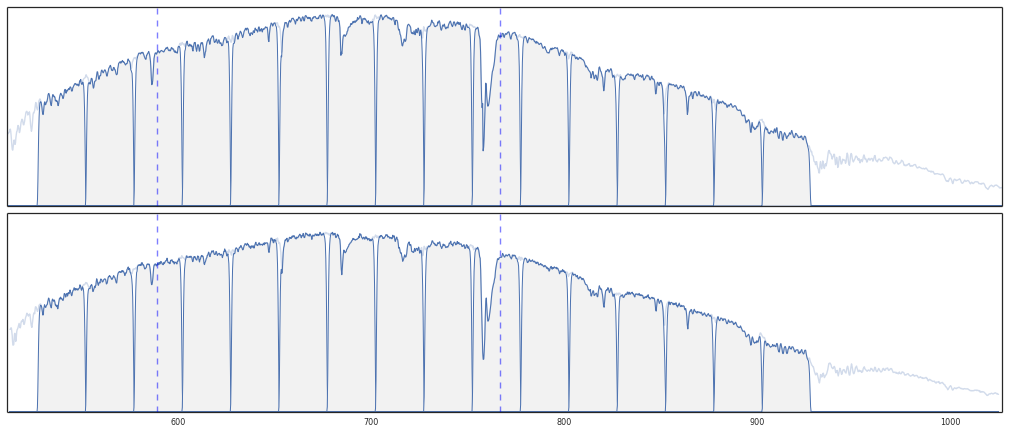

In [10]:
fig,ax = subplots(2,1,figsize=(14,6), sharey=True, sharex=True)
nsp1 = normalise(spectra_1[0])
nsp2 = normalise(spectra_2[0])
[ax[0].fill(wl1, f(wl1)*nsp1, ec=cp[0], lw=1, fc='0.95') for f in pb_filters_nb]
ax[0].plot(wl1, normalise(spectra_1[0]), c=cp[0], alpha=0.25)
[ax[1].fill(wl2, f(wl2)*nsp2, ec=cp[0], lw=1, fc='0.95') for f in pb_filters_nb]
ax[1].plot(wl2, normalise(spectra_2[0]), c=cp[0], alpha=0.25)
[a.axvline(589.4, ls='--', alpha=0.5) for a in ax]
[a.axvline(767, ls='--', alpha=0.5) for a in ax]
setp(ax, xlim=(wl1[[0,-1]]), ylim=(0,1.6), yticks=[])
fig.tight_layout()

## Create the spectrum mask

In [11]:
f = normalise(spectra_2/spectra_1)
fs = f.std(0)
fm = abs(mf(fs,101) - fs) < 0.002

/home/parviainen/.local/lib/python2.7/site-packages/matplotlib-1.3.1-py2.7-linux-x86_64.egg/matplotlib/scale.py:90: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0
/home/parviainen/.local/lib/python2.7/site-packages/numpy/ma/core.py:802: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


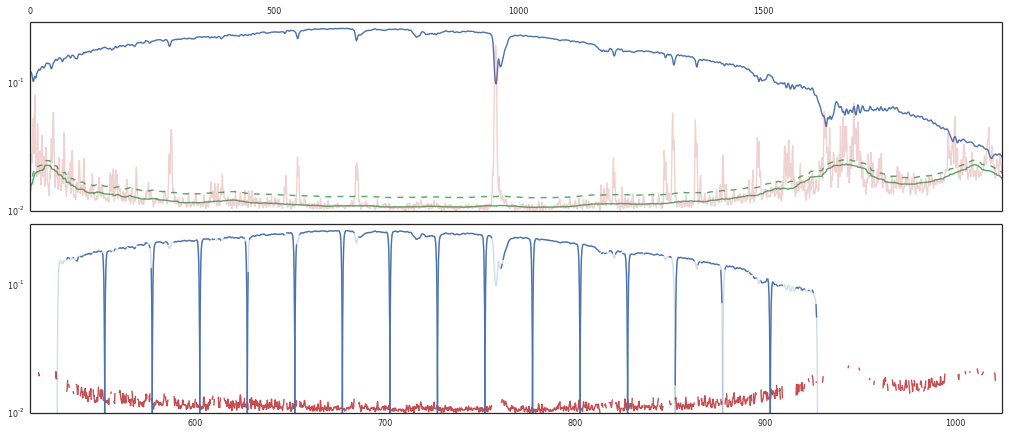

In [12]:
fig,ax = subplots(2,1, figsize=(14,6), sharey=True, sharex=True)
ax_pix = ax[0].twiny()
ax[0].semilogy(wl2, spectra_2.mean(0)/3e5, c=cp[0])
ax[0].semilogy(wl2, mf(fs,101), c=cp[1])
ax[0].semilogy(wl2, mf(fs,101)+0.002, '--', c=cp[1])
ax[0].semilogy(wl2, fs, alpha=0.25, c=cp[2])
ax[1].semilogy(wl2, where(fm, fs,np.nan), c=cp[2])
[ax[1].semilogy(wl2, f(wl2)*spectra_2.mean(0)/3e5, c=cp[0], alpha=0.25) for f in pb_filters_nb]
[ax[1].semilogy(wl2, f(wl2)*where(fm, spectra_2.mean(0)/3e5,np.nan), c=cp[0]) for f in pb_filters_nb]
setp(ax, ylim=(1e-2,3e-1), xlim=wl2[[0,-1]])
setp(ax_pix, xlim=(0,wl2.size))
fig.tight_layout()

## Create the light curves

The light curves are name as `lc_BB_N_MMMMMM` where `BB` is either `nb` for a narrow band or `bb` for the broad passband, `N` is 1 for the reference star and `2` for TrES-3, and `MMMMMM` is either `mask` or `nomask`.

In [13]:
lc_nb_1_nomask = array([[mean(f(wl1)*s) for f in pb_filters_nb] for s in spectra_1])
lc_nb_2_nomask = array([[mean(f(wl2)*s) for f in pb_filters_nb] for s in spectra_2])

In [14]:
lc_nb_1_masked = array([[nanmean(f(wl1)*where(fm,s,nan)) for f in pb_filters_nb] for s in spectra_1])
lc_nb_2_masked = array([[nanmean(f(wl2)*where(fm,s,nan)) for f in pb_filters_nb] for s in spectra_2])

In [15]:
lc_bb_1_nomask = array([mean(pb_filter_bb(wl1)*s) for s in spectra_1])
lc_bb_2_nomask = array([mean(pb_filter_bb(wl2)*s) for s in spectra_2])
lc_bb_1_masked = array([nanmean(pb_filter_bb(wl1)*where(fm,s,nan)) for s in spectra_1])
lc_bb_2_masked = array([nanmean(pb_filter_bb(wl2)*where(fm,s,nan)) for s in spectra_2])

In [16]:
lc_bb_nomask = normalise(lc_bb_2_nomask/lc_bb_1_nomask)
lc_bb_masked = normalise(lc_bb_2_masked/lc_bb_1_masked)
lc_nb_nomask = array([normalise(lc) for lc in (lc_nb_2_nomask/lc_nb_1_nomask).T]).T
lc_nb_masked = array([normalise(lc) for lc in (lc_nb_2_masked/lc_nb_1_masked).T]).T

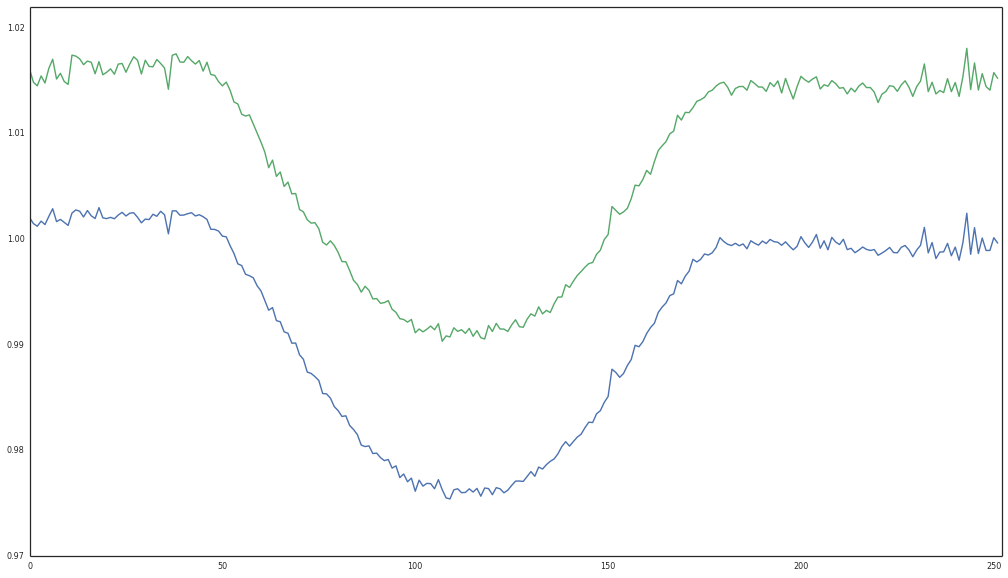

In [17]:
fig,ax = subplots(1,1,figsize=(14,8), sharey=True, sharex=True)
ax.plot(normalise(lc_bb_2_nomask/lc_bb_1_nomask))
ax.plot(0.015+normalise(lc_bb_2_masked/lc_bb_1_masked))
setp(ax, xlim=[0,lc_nb_2_nomask.shape[0]], ylim=[0.97,1.022])
fig.tight_layout()

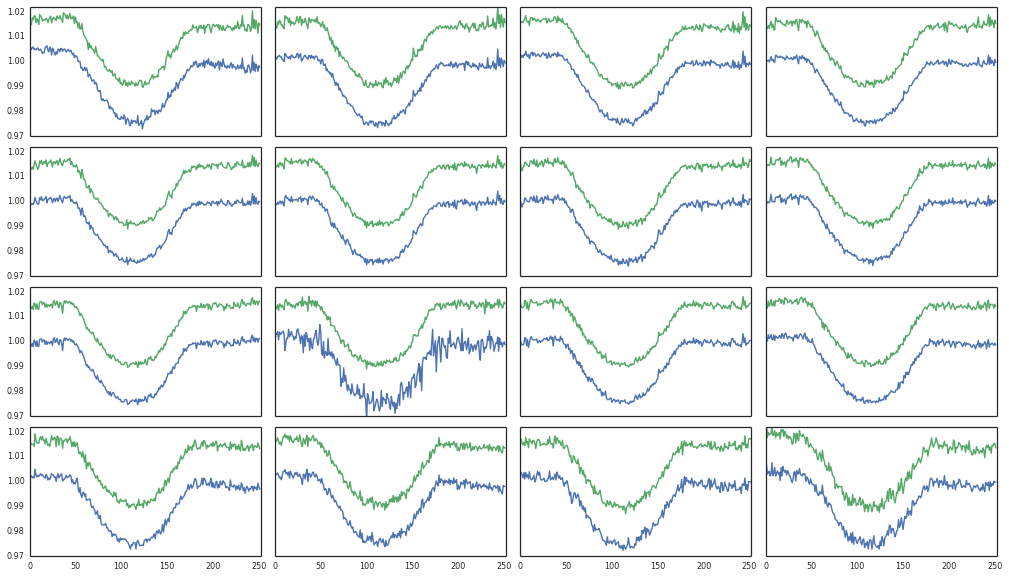

In [18]:
fig,axs = subplots(4,4,figsize=(14,8), sharey=True, sharex=True)
for i,a in enumerate(axs.flat):
    a.plot(normalise(lc_nb_2_nomask[:,i]/lc_nb_1_nomask[:,i]))
    a.plot(0.015+normalise(lc_nb_2_masked[:,i]/lc_nb_1_masked[:,i]))
setp(axs, xlim=[0,lc_nb_2_nomask.shape[0]], ylim=[0.97,1.022])
fig.tight_layout()

## Create bad-point mask 

In [19]:
bmsk = ones(lc_bb_nomask.size, np.bool)
bmsk[[151,152]] = 0
bmsk[230:] = 0

## Get the auxiliary parameters

In [20]:
time, airmass, humidity, pressure = [],[],[],[]

for fn in sfiles_1:
    f = pf.open(fn)
    time.append(f[0].header['date-obs'])
    airmass.append(f[0].header['airmass'])
    humidity.append(f[0].header['humidity'])
    pressure.append(f[0].header['pressure'])
    f.close()
mjd = Time(time).mjd

df_aux = pd.DataFrame(transpose([mjd,airmass,humidity,pressure,bmsk]), 
                  columns='mjd airmass humidity pressure bad_mask'.split())

In [21]:
df_filters = pd.DataFrame(transpose([f(wl2) for f in pb_filters_nb]), columns=pb_centers)

## Write the light curves and the auxiliary data into a HDF5 file 

In [22]:
bbargs = dict(columns=['white'], index=mjd)
nbargs = dict(columns=pb_centers, index=mjd)

hdf = pd.HDFStore('results/light_curves.h5')
hdf.put('aux', df_aux, format='table', data_columns=True)
hdf.put('filters', df_aux, format='table', data_columns=True)
hdf.put('final/bb_nomask',     DF(lc_bb_nomask,   **bbargs), format='table', data_columns=True)
hdf.put('final/bb_masked',     DF(lc_bb_masked,   **bbargs), format='table', data_columns=True)
hdf.put('final/nb_nomask',     DF(lc_nb_nomask,   **nbargs), format='table', data_columns=True)
hdf.put('final/nb_masked',     DF(lc_nb_masked,   **nbargs), format='table', data_columns=True)
hdf.put('target/bb_nomask',    DF(lc_bb_2_nomask, **bbargs), format='table', data_columns=True)
hdf.put('target/bb_masked',    DF(lc_bb_2_masked, **bbargs), format='table', data_columns=True)
hdf.put('target/nb_nomask',    DF(lc_nb_2_nomask, **nbargs), format='table', data_columns=True)
hdf.put('target/nb_masked',    DF(lc_nb_2_masked, **nbargs), format='table', data_columns=True)
hdf.put('reference/bb_nomask', DF(lc_bb_1_nomask, **bbargs), format='table', data_columns=True)
hdf.put('reference/bb_masked', DF(lc_bb_1_masked, **bbargs), format='table', data_columns=True)
hdf.put('reference/nb_nomask', DF(lc_nb_1_nomask, **nbargs), format='table', data_columns=True)
hdf.put('reference/nb_masked', DF(lc_nb_1_nomask, **nbargs), format='table', data_columns=True)
hdf.close()

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>